# Chapter Scheduled Prompt Parsing

In [1]:
%pip install compel
%pip install lark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 879.0 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## 1. Use Compel package

In [1]:
import torch
from diffusers import StableDiffusionPipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2",
    torch_dtype = torch.float16,
    safety_checker = None
).to("cuda:0")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers

  0%|          | 0/50 [00:00<?, ?it/s]

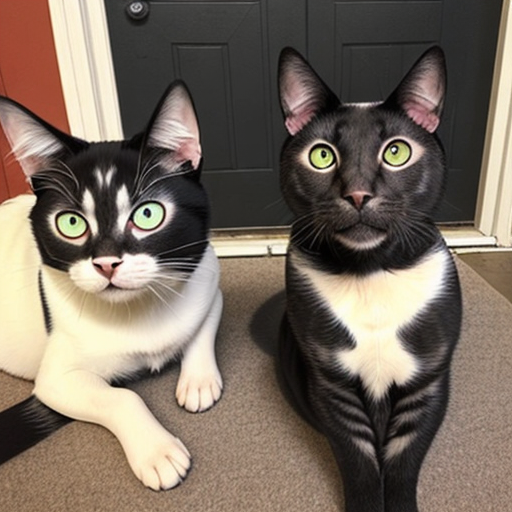

In [2]:
image = pipeline(
    prompt = "A photo with half cat and half dog"
    , generator = torch.Generator("cuda:0").manual_seed(3)
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

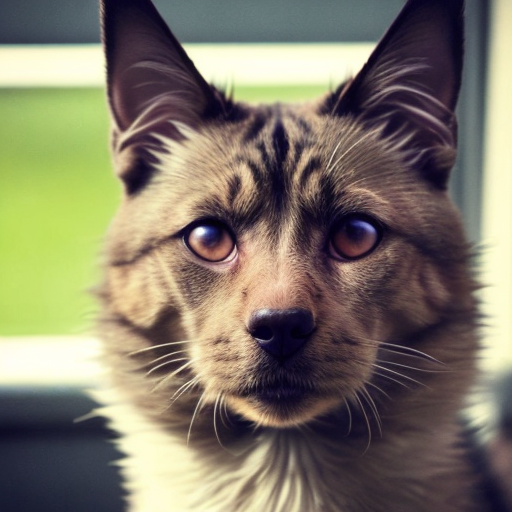

In [3]:
# A sample of blending
from compel import Compel
compel = Compel(
    tokenizer     = pipeline.tokenizer,
    text_encoder  = pipeline.text_encoder
)

prompt = '("A photo of cat", "A photo of dog").blend(0.5, 0.5)'
prompt_embeds = compel(prompt)

image = pipeline(
    prompt_embeds = prompt_embeds
    , generator = torch.Generator("cuda:0").manual_seed(3)
).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

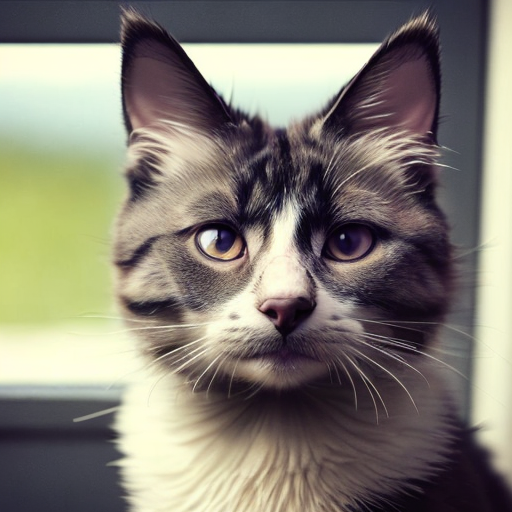

In [5]:
# 0.7 cat, 0.3 dog blending
prompt = '("A photo of cat", "A photo of dog").blend(0.7, 0.3)'
prompt_embeds = compel(prompt)

image = pipeline(
    prompt_embeds = prompt_embeds
    , generator = torch.Generator("cuda:0").manual_seed(3)
).images[0]
image

## 2. Build a custom pipeline

### 2.1 A scheduled prompt parser 

In [6]:
import lark
schedule_parser = lark.Lark(r"""
!start: (prompt | /[][():]/+)*
prompt: (emphasized | scheduled | alternate | plain | WHITESPACE)*
!emphasized: "(" prompt ")"
        | "(" prompt ":" prompt ")"
        | "[" prompt "]"
scheduled: "[" [prompt ":"] prompt ":" [WHITESPACE] NUMBER "]"
alternate: "[" prompt ("|" prompt)+ "]"
WHITESPACE: /\s+/
plain: /([^\\\[\]():|]|\\.)+/
%import common.SIGNED_NUMBER -> NUMBER
""")

def get_learned_conditioning_prompt_schedules(prompts, steps):
    def collect_steps(steps, tree):
        l = [steps]
        class CollectSteps(lark.Visitor):
            def scheduled(self, tree):
                tree.children[-1] = float(tree.children[-1])
                if tree.children[-1] < 1:
                    tree.children[-1] *= steps
                tree.children[-1] = min(steps, int(tree.children[-1]))
                l.append(tree.children[-1])
            def alternate(self, tree):
                l.extend(range(1, steps+1))
        CollectSteps().visit(tree)
        return sorted(set(l))

    def at_step(step, tree):
        class AtStep(lark.Transformer):
            def scheduled(self, args):
                before, after, _, when = args
                yield before or () if step <= when else after
            def alternate(self, args):
                yield next(args[(step - 1)%len(args)])
            def start(self, args):
                def flatten(x):
                    if type(x) == str:
                        yield x
                    else:
                        for gen in x:
                            yield from flatten(gen)
                return ''.join(flatten(args))
            def plain(self, args):
                yield args[0].value
            def __default__(self, data, children, meta):
                for child in children:
                    yield child
        return AtStep().transform(tree)

    def get_schedule(prompt):
        try:
            tree = schedule_parser.parse(prompt)
        except lark.exceptions.LarkError as e:
            if 0:
                import traceback
                traceback.print_exc()
            return [[steps, prompt]]
        return [[t, at_step(t, tree)] for t in collect_steps(steps, tree)]

    promptdict = {prompt: get_schedule(prompt) for prompt in set(prompts)}
    return [promptdict[prompt] for prompt in prompts]


In [7]:
steps = 10
g = lambda p: get_learned_conditioning_prompt_schedules([p], steps)[0]

In [8]:
g("cat")

[[10, 'cat']]

In [9]:
g('[cat:dog:0.5]')

[[5, 'cat'], [10, 'dog']]

In [10]:
g('[cat|dog]')

[[1, 'cat'],
 [2, 'dog'],
 [3, 'cat'],
 [4, 'dog'],
 [5, 'cat'],
 [6, 'dog'],
 [7, 'cat'],
 [8, 'dog'],
 [9, 'cat'],
 [10, 'dog']]

### 2.2 Fill the missing steps

In [11]:
def parse_scheduled_prompts(text,steps=10):
    text = text.strip()
    parse_result = None
    try:
        parse_result = get_learned_conditioning_prompt_schedules([text],steps=steps)[0]
    except Exception as e:
        print(e)

    if len(parse_result) == 1:
        # no scheduling
        return parse_result
    
    prompts_list = []
    
    for i in range(steps):
        current_prompt_step, current_prompt_content = parse_result[0][0],parse_result[0][1]
        step = i + 1
        if step < current_prompt_step:
            prompts_list.append(current_prompt_content)
            continue
        
        if step == current_prompt_step:
            prompts_list.append(current_prompt_content)
            parse_result.pop(0)
        
    return prompts_list


In [12]:
prompt_list = parse_scheduled_prompts("[cat:dog:0.5]")
prompt_list

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog']

### 2.3 A Stable Diffusion Pipeline support scheduled prompts

In [13]:
from typing import List, Callable, Dict, Any
from torch import Generator,FloatTensor
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
import torch

class StableDiffusionPipeline_EXT(StableDiffusionPipeline):
    @torch.no_grad()
    def scheduler_call(
        self
        , prompt: str | List[str] = None
        , height: int | None = 512
        , width: int | None = 512
        , num_inference_steps: int = 50
        , guidance_scale: float = 7.5
        , negative_prompt: str | List[str] | None = None
        , num_images_per_prompt: int | None = 1
        , eta: float = 0
        , generator: Generator | List[Generator] | None = None
        , latents: FloatTensor | None = None
        , prompt_embeds: FloatTensor | None = None
        , negative_prompt_embeds: FloatTensor | None = None
        , output_type: str | None = "pil"
        , callback: Callable[[int, int, FloatTensor], None] | None = None
        , callback_steps: int = 1
        , cross_attention_kwargs: Dict[str, Any] | None = None
    ):        
        # 1. set default scheduler to EulerDiscreteScheduler
        if self.scheduler._class_name == "PNDMScheduler":
            self.scheduler = EulerDiscreteScheduler.from_config(
                self.scheduler.config
            )
            
        # 2. Prepare parameters `device` and `do_classifier_free_guidance`
        device = self._execution_device
        do_classifier_free_guidance = guidance_scale > 1.0
        
        # 3. get the prompt list by parsing 
        prompt_list = parse_scheduled_prompts(prompt)
        
        embedding_list = []
        # 4. If no scheduled prompt is found, use the normal single prompt logic
        if len(prompt_list) == 1:
            prompt_embeds = self._encode_prompt(
                prompt,
                device,
                num_images_per_prompt,
                do_classifier_free_guidance,
                negative_prompt,
                negative_prompt_embeds=negative_prompt_embeds,
            )
        else:
            for prompt in prompt_list:
                prompt_embeds = self._encode_prompt(
                    prompt,
                    device,
                    num_images_per_prompt,
                    do_classifier_free_guidance,
                    negative_prompt,
                    negative_prompt_embeds=negative_prompt_embeds,
                )
                embedding_list.append(prompt_embeds)
        
        # 5. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 6. Prepare latent variables
        num_channels_latents = self.unet.in_channels
        batch_size = 1
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # custom code to enable Prompt Scheduling, will only function when 
                # there is a prompt_embeds_l provided. 
                prompt_embeds_l_len = len(embedding_list)
                if prompt_embeds_l_len > 0:
                    # ensure no None prompt will be used
                    pe_index = (i)%prompt_embeds_l_len                      
                    prompt_embeds = embedding_list[pe_index]

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # 8. Post processing
        image = self.decode_latents(latents)
        image = self.numpy_to_pil(image)
        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=None)

In [14]:
pipeline = StableDiffusionPipeline_EXT.from_pretrained(
    "stablediffusionapi/deliberate-v2",
    torch_dtype = torch.float16,
    safety_checker = None
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.StableDiffusionPipeline_EXT'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `_class_name` directly via 'PNDMScheduler' object attribute is deprecated. Please access '_class_name' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config._class_name'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
C:\Us

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


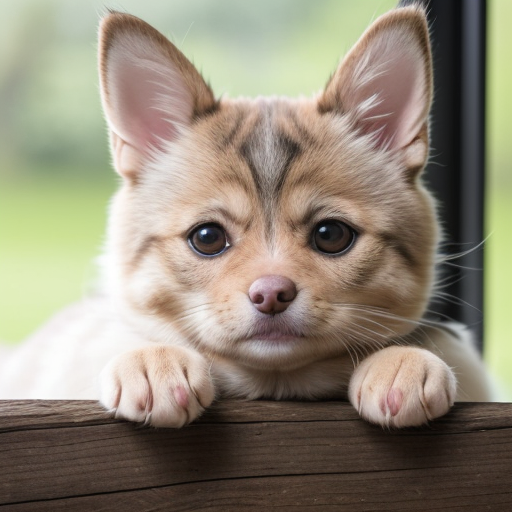

In [15]:
prompt = "high quality, 4k, details, A realistic photo of cute [cat:dog:0.6]"
neg_prompt = "paint, oil paint, animation, blur, low quality, bad glasses"
image = pipeline.scheduler_call(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(3)
).images[0]
image

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `_class_name` directly via 'EulerDiscreteScheduler' object attribute is deprecated. Please access '_class_name' over 'EulerDiscreteScheduler's config object instead, e.g. 'scheduler.config._class_name'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
C:\Users\Asus\AppData\Local\Temp\ipykernel_28612\2989763371.py:69: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

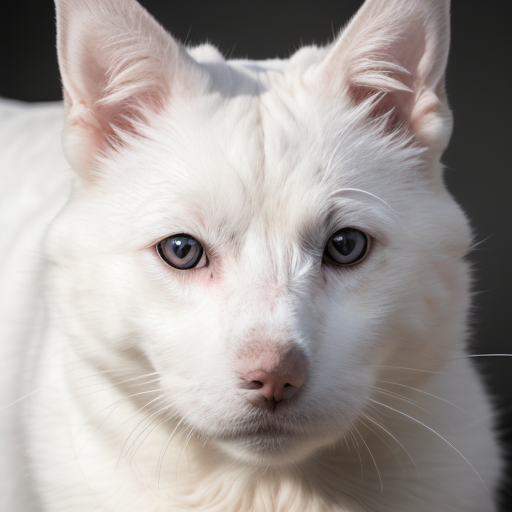

In [16]:
prompt = "high quality, 4k, details, A realistic photo of white [cat|dog]"
neg_prompt = "paint, oil paint, animation, blur, low quality, bad glasses"
image = pipeline.scheduler_call(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(3)
).images[0]
image